# **Projeto Determinação de Tamanho de Grãos**

Esse projeto consiste na utilização de técnicas de Processamento de Imagens para realizar a determinação de tamanho de grão para imagens de micrografia de metais. Essa tarefa é atualmente realizada manualmente por estudantes de Engenharia de Materiais. 

O objetivo final é a criação de um site ou aplicativo para computador ou smartphone que realize essa tarefa automaticamente. 
No início serão feitas reuniões semanais presenciais para aprendizado das técnicas, até que todos tenham certo domínio e possam entender e executar as tarefas para resolver o problema. No estágio final, será feita a exportação para um aplicativo.

##Para utilizar este projeto, use *CTRL+F9* ou *Runtime>Run All*
##faça o upload da imagem desejada e veja o resultado no final da página.

In [1]:
import cv2; import numpy as np; import matplotlib.pyplot as plt
from io import BytesIO; from PIL import Image

show = True
colabs = False
n_real = 0

In [15]:
from ipywidgets import interact
def square(x):
    return x * x
interact(square, x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.square(x)>

In [2]:
#Fazendo upload da imagem
if colabs:
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))

(1342, 1600, 3)


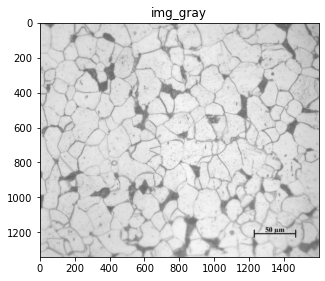

In [3]:
#Abrindo imagem
if colabs:
    file_name = list(uploaded)[0]
    img = Image.open(BytesIO(uploaded[file_name]))
    img = np.asarray(img)
else:
    img = plt.imread('data/aço 1010 50x - corrigido (1).jpg')

print(img.shape)

#Conversão de uma imagem para outro sistema de cores
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Visualização de imagem individual
if show: plt.figure(figsize=(5,5)); plt.title("img_gray"); fig = plt.imshow(img_gray, 'gray')

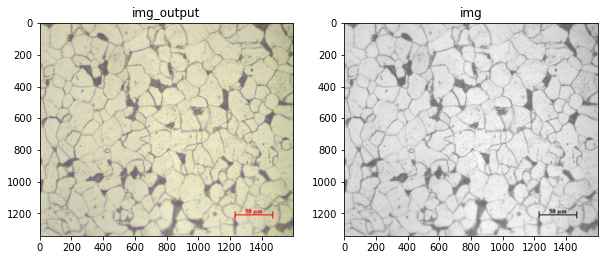

In [4]:
#Visualização de várias imagens
if show: plt.figure(figsize= (10,10))
if show: plt.subplot(121); plt.title('img_output'); fig=plt.imshow(img, 'gray')
if show: plt.subplot(122); plt.title('img'); fig=plt.imshow(img_gray, 'gray')

dtype= uint8


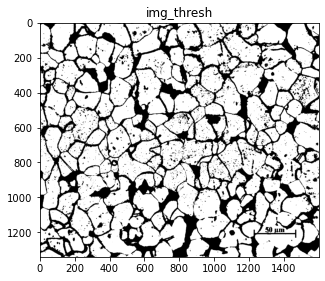

In [5]:
#Adaptivo
img_thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 199, 3) 
print("dtype=", img_thresh.dtype)
if show: plt.figure(figsize=(5,5)); plt.title("img_thresh"); fig = plt.imshow(img_thresh, 'gray')

dtype= uint8


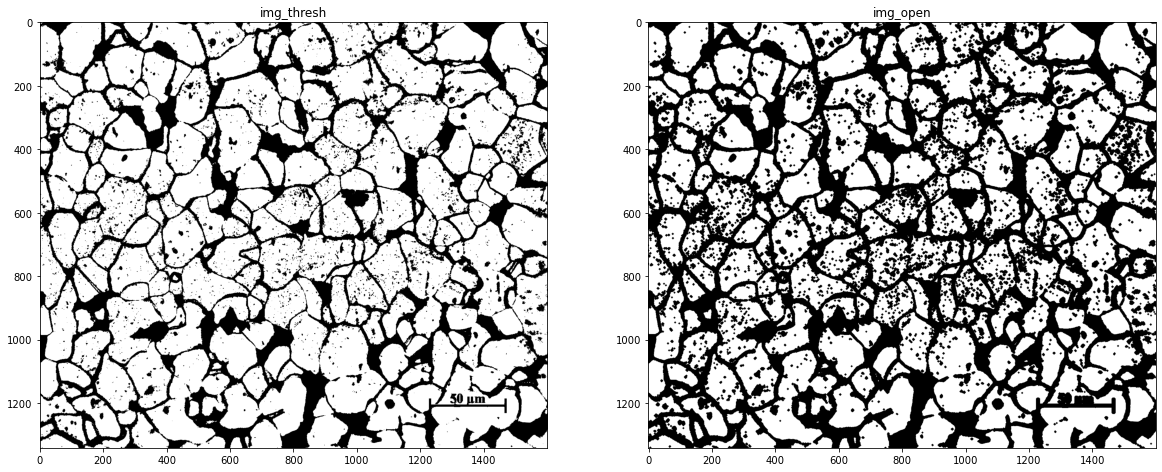

In [6]:
#Fechamento
def getCircle(n):
    '''kernel has size NxN'''
    # xx and yy are 200x200 tables containing the x and y coordinates as values
    # mgrid is a mesh creation helper
    xx, yy = np.mgrid[:n,:n]
    # circles contains the squared distance to the (100, 100) point
    # we are just using the circle equation learnt at school
    circle = (xx - np.floor(n/2)) ** 2 + (yy - np.floor(n/2)) ** 2
    circle = circle<=np.max(circle)*.5
    circle = np.uint8(circle)
    return circle

kernel = getCircle(3)
img_open = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 0)
img_open = cv2.erode(img_open, kernel, iterations=3)
print("dtype=", img_open.dtype)

if show: plt.figure(figsize= (20,20))
if show: plt.subplot(121); plt.title('img_thresh'); fig=plt.imshow(img_thresh, 'gray')
if show: plt.subplot(122); plt.title('img_open'); fig=plt.imshow(img_open, 'gray')

uint8


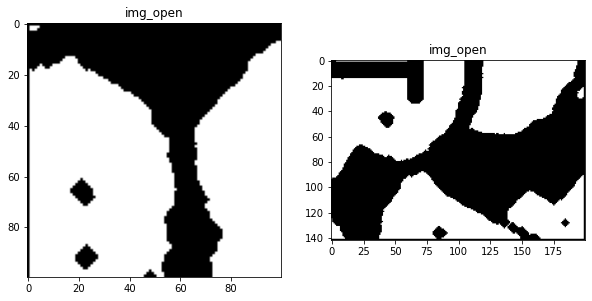

In [7]:
#Desenhando borda na imagem
y,x = img_open.shape
print(img_open.dtype)
color = 0
img_open[:,   0] = 0; img_open[:, x-1] = 0; img_open[0,   :] = 0; img_open[y-1, :] = 0

if show: plt.figure(figsize= (10,10))
if show: plt.subplot(121); plt.title('img_open'); fig = plt.imshow(img_open[:100,:100], 'gray')
if show: plt.subplot(122); plt.title('img_open'); fig = plt.imshow(img_open[1200:,1400:], 'gray')

n_contours_before = 431
n_contours_after = 234


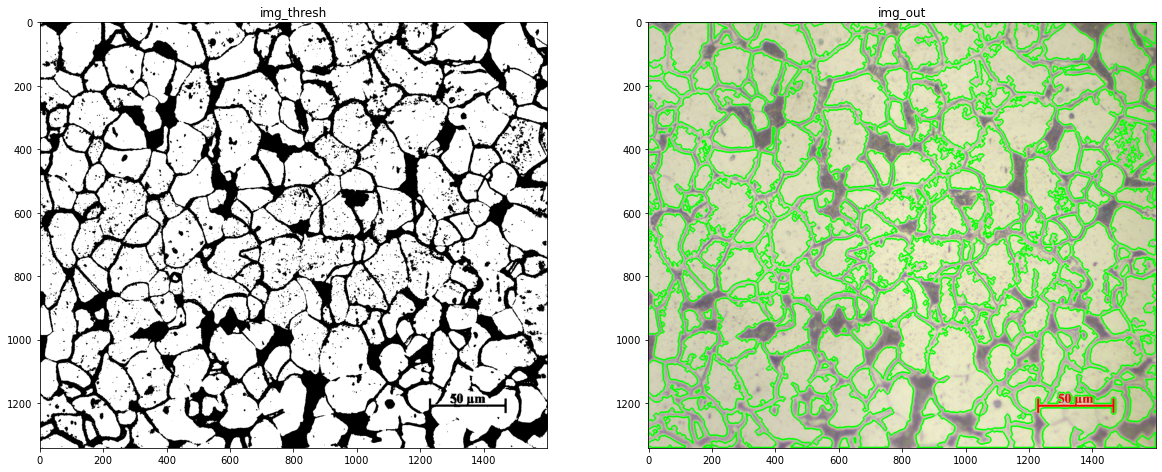

In [8]:
#Gerando Lista de Contornos
cv2MajorVersion = cv2.__version__.split(".")[0]
if int(cv2MajorVersion) >= 4:
    contours, _= cv2.findContours(img_open,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
else:
    _, contours, _ = cv2.findContours(img_open,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Ordenando Lista de Contornos de acordo com a área
contours = sorted(contours, key = cv2.contourArea, reverse = True)
print("n_contours_before =", len(contours))

#Selecionando apenas contornos cuja área é maior que algum valor
min_area = 20.0
contours = [c for c in contours if cv2.contourArea(c)>min_area]
print("n_contours_after =", len(contours))

#Desenhando Contornos na imagem original
verde = (0,255,0)
img_out = cv2.drawContours(img.copy(), contours, -1, verde, 3)

if show: plt.figure(figsize= (20,20))
if show: plt.subplot(121); plt.title('img_thresh'); fig=plt.imshow(img_thresh, 'gray')
if show: plt.subplot(122); plt.title('img_out'); fig=plt.imshow(img_out, 'gray')

53


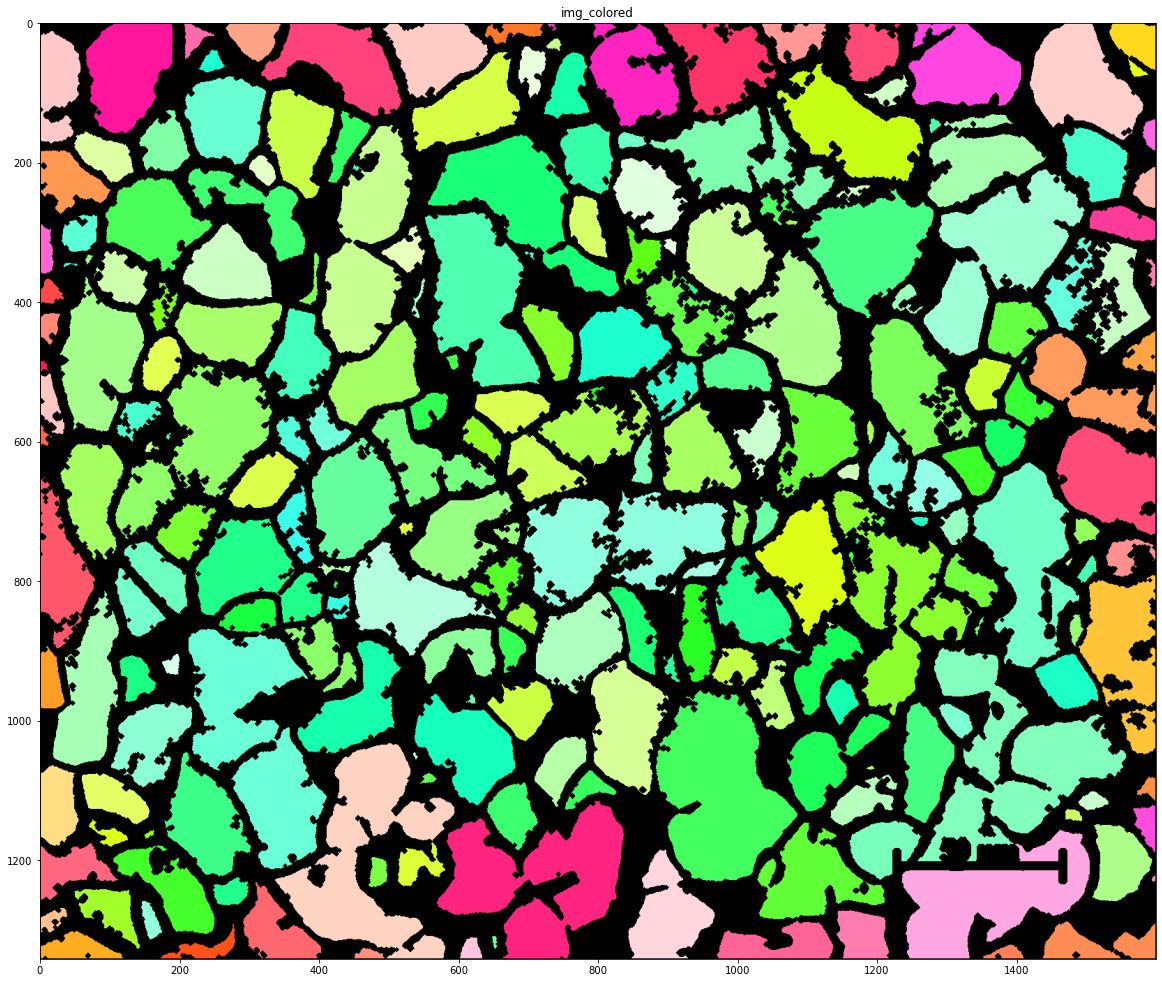

In [9]:
faixa = 3
n_borda = 0
img_colored = np.int32(np.ones(img.shape))
red = [0,255,0]
blue = [255,0,0]
for c in contours:
    (x_ini,y_ini,w,h) = cv2.boundingRect(c)
    x_end = x_ini+w; y_end = y_ini+h
    y_img, x_img = img_thresh.shape
    
    if 0<x_ini<faixa or 0<y_ini<faixa or x_img-faixa<x_end<x_img or y_img-faixa<y_end<y_img:
        n_borda +=1
        random_red = [np.random.randint(20, 235) for i in range(3)]
        random_red[0] = 255
        img_colored = cv2.fillPoly(img_colored, [c], random_red)
    else:
        random_blue = [np.random.randint(20, 235) for i in range(3)]
        random_blue[1] = 255
        img_colored = cv2.fillPoly(img_colored, [c], random_blue)
print(n_borda)
if show: plt.figure(figsize=(20,20)); plt.title("img_colored"); fig = plt.imshow(img_colored, 'gray')

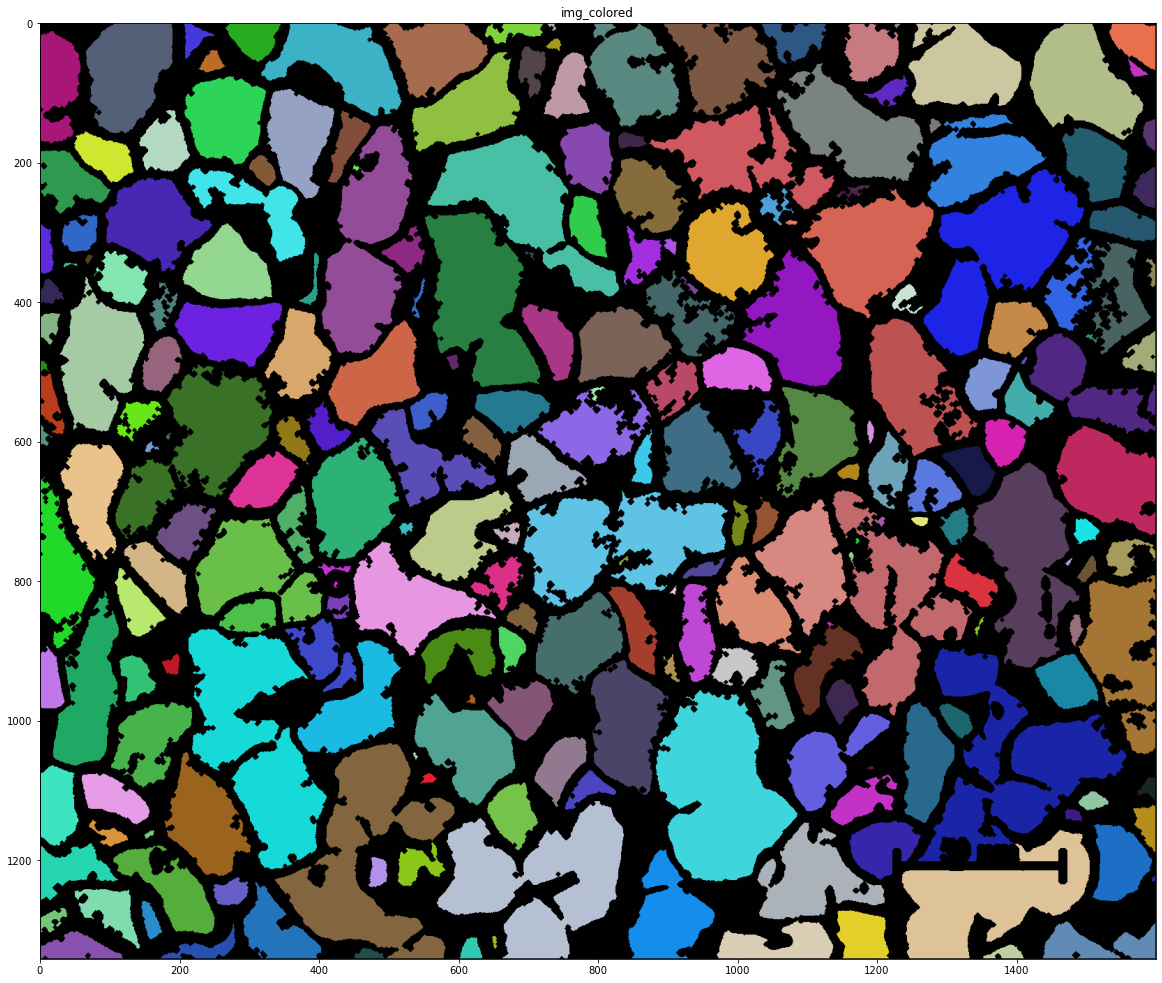

In [10]:
#Preenchendo contornos
img_colored = np.int32(np.ones(img.shape))
img_out = img.copy()
for c in contours:
    random_color = [np.random.randint(20, 235) for i in range(3)]
    img_colored = cv2.fillPoly(img_colored, [c], random_color)
    img_out = cv2.drawContours(img_out, [c], -1, random_color, 3)
    
if show: plt.figure(figsize=(20,20)); plt.title("img_colored"); fig = plt.imshow(img_colored, 'gray')

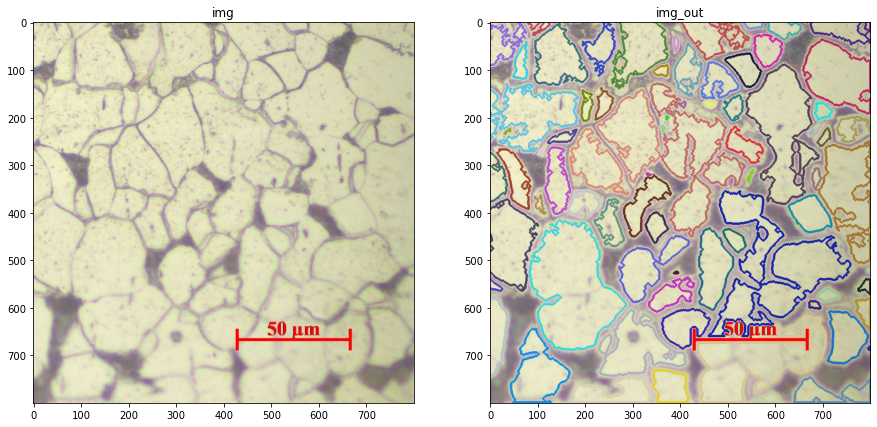

In [11]:
#Visualizando novamente
plt.figure(figsize= (15,15))
plt.subplot(121); plt.title('img'); fig=plt.imshow(img[-800:,-800:], 'gray')
plt.subplot(122); plt.title('img_out'); fig=plt.imshow(img_out[-800:,-800:], 'gray')

In [12]:
print("n_contours =", len(contours))
print("n_borda =", n_borda)
resultado = len(contours)-round(n_borda/2)
print("resultado =", resultado, "grãos")

n_contours = 234
n_borda = 53
resultado = 208 grãos


In [13]:
if n_real>0:
    print("n_real =", n_real)
    erro = abs(n_real-resultado)
    print("erro =", erro)